In [1]:
import yaml
from context import Dataset
from context import Predictor_CVM
from context import Predictor_sof, Predictor_zan, Predictor_kara, Newclass, TrajectronPredictor, SGANPredictor
from context import Evaluator


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


['/home/pal2rng/Code/Students/the-atlas-benchmark/Trajectron-plus-plus/trajectron', '/home/pal2rng/Code/Students/the-atlas-benchmark/src', '/home/pal2rng/Code/Students/the-atlas-benchmark/demo', '/home/pal2rng/.conda/envs/atlas-env/lib/python37.zip', '/home/pal2rng/.conda/envs/atlas-env/lib/python3.7', '/home/pal2rng/.conda/envs/atlas-env/lib/python3.7/lib-dynload', '', '/home/pal2rng/.conda/envs/atlas-env/lib/python3.7/site-packages', '/home/pal2rng/.conda/envs/atlas-env/lib/python3.7/site-packages/IPython/extensions', '/home/pal2rng/.ipython', '/home/pal2rng/.local/lib/python3.7/site-packages', '..', '..', '..', '..']


Create the dataset object based on the yaml file configuration

In [2]:
# Tested this instruction for the following datasets
# input_dataset = '../cfg/dataset_config_hotel.yaml'
input_dataset = '../cfg/dataset_config_eth.yaml'
# input_dataset = '../cfg/dataset_config_thor1.yaml'
# input_dataset = '../cfg/dataset_config_thor3.yaml'
# input_dataset = '../cfg/dataset_config_atc.yaml'
# input_dataset = '../cfg/dataset_config_test_traj.yaml'
# input_dataset = '../cfg/dataset_config_test_point_obstacles.yaml'

with open(input_dataset, 'r') as file:
    benchmark_cfg = yaml.load(file, Loader=yaml.FullLoader)

# Optional split parameter defines the portion of the dataset that is being extracted,
# frames between 0 * length(dataset) and 1 * length(dataset)
dataset = Dataset(benchmark_cfg, split=[0,1])

Preparing a list of scenarios with valid observations and complete ground truth

In [3]:
#observation_len = benchmark_cfg['benchmark']['setup']['observation period']
#prediction_horizon = benchmark_cfg['benchmark']['setup']['prediction horizon']

observation_len = 8 # benchmark_cfg['benchmark']['setup']['observation period']
prediction_horizon = 8 # benchmark_cfg['benchmark']['setup']['prediction horizon']

# Here we iterate over all possible start frames in the dataset and extract the valid scenarios
# with sufficient observations for all detected pedestrians and the ground truth data
valid_scenes = dataset.extract_scenarios(prediction_horizon, observation_len)

The eth dataset has 50 valid scenes with observation length 8 and prediction horizon 8 out of 1930 scenes total.


Initiating a predictor and calculating predictions for one scene. This time we consider only one aprticle without uncertainty.

In [4]:
%xmode Verbose
%tb
with open('../cfg/method_config_trajectronpp.yaml', 'r') as file:
    method_cfg = yaml.load(file, Loader=yaml.FullLoader)

method_cfg['uncertainty'] = False
predictor_certain = SGANPredictor(valid_scenes[1], dataset)

predictions = predictor_certain.predict(valid_scenes[1])

print(f'Time spent for prediction {predictions.runtime}')



Exception reporting mode: Verbose


No traceback available to show.


Time spent for prediction 0.20319032669067383


Now we can evaluate the predictions against the ground truth

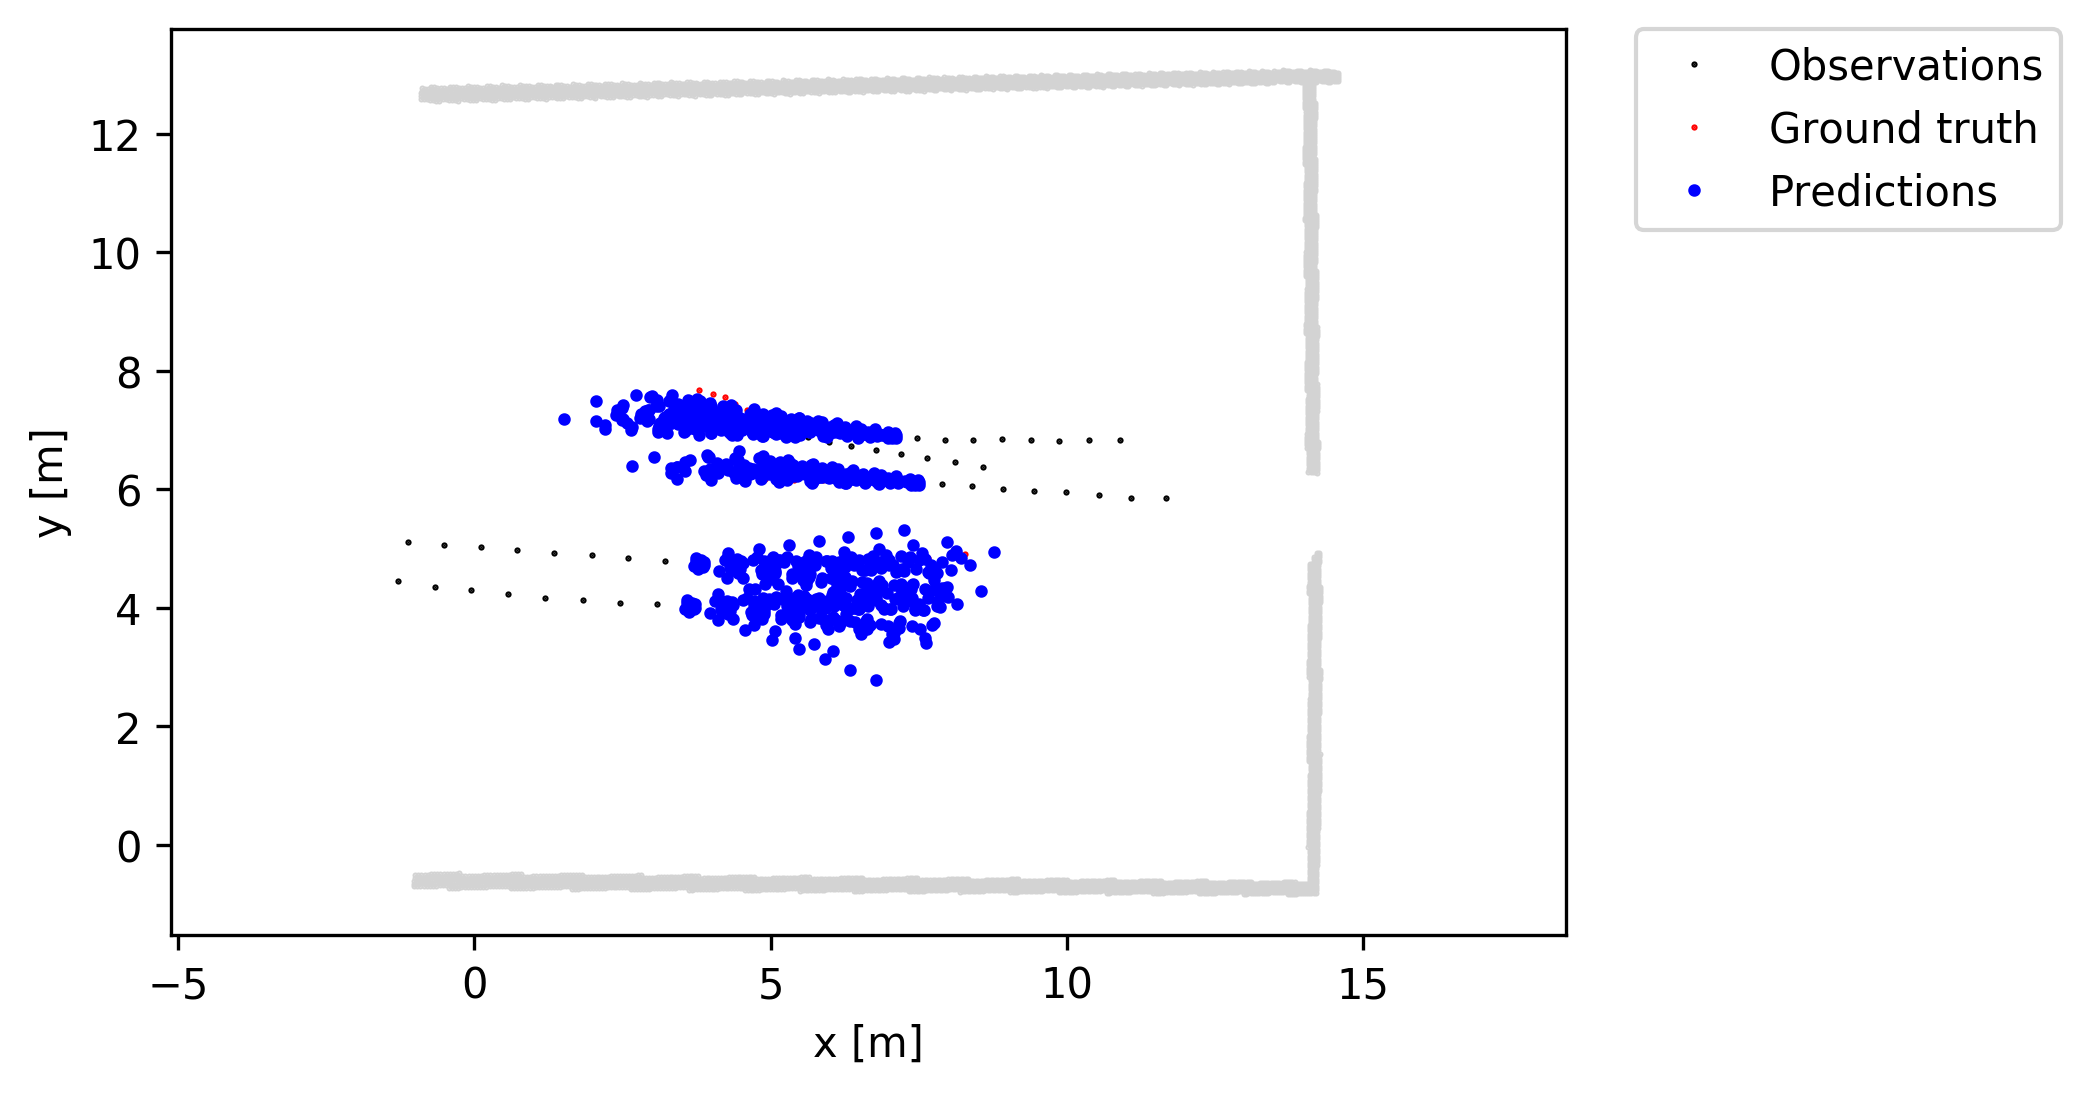

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

evaluation = Evaluator(set_GT_length=prediction_horizon)

# evaluation.evaluate_scenario_ade_fde(valid_scenes[19], predictions)
evaluation.plot_scenario(dataset, valid_scenes[1], predictions)

The same visualization for an uncertain predictor


Loading from /home/pal2rng/Code/Students/the-atlas-benchmark/Trajectron-plus-plus/experiments/pedestrians/models/eth_attention_radius_3/model_registrar-100.pt
Loaded!



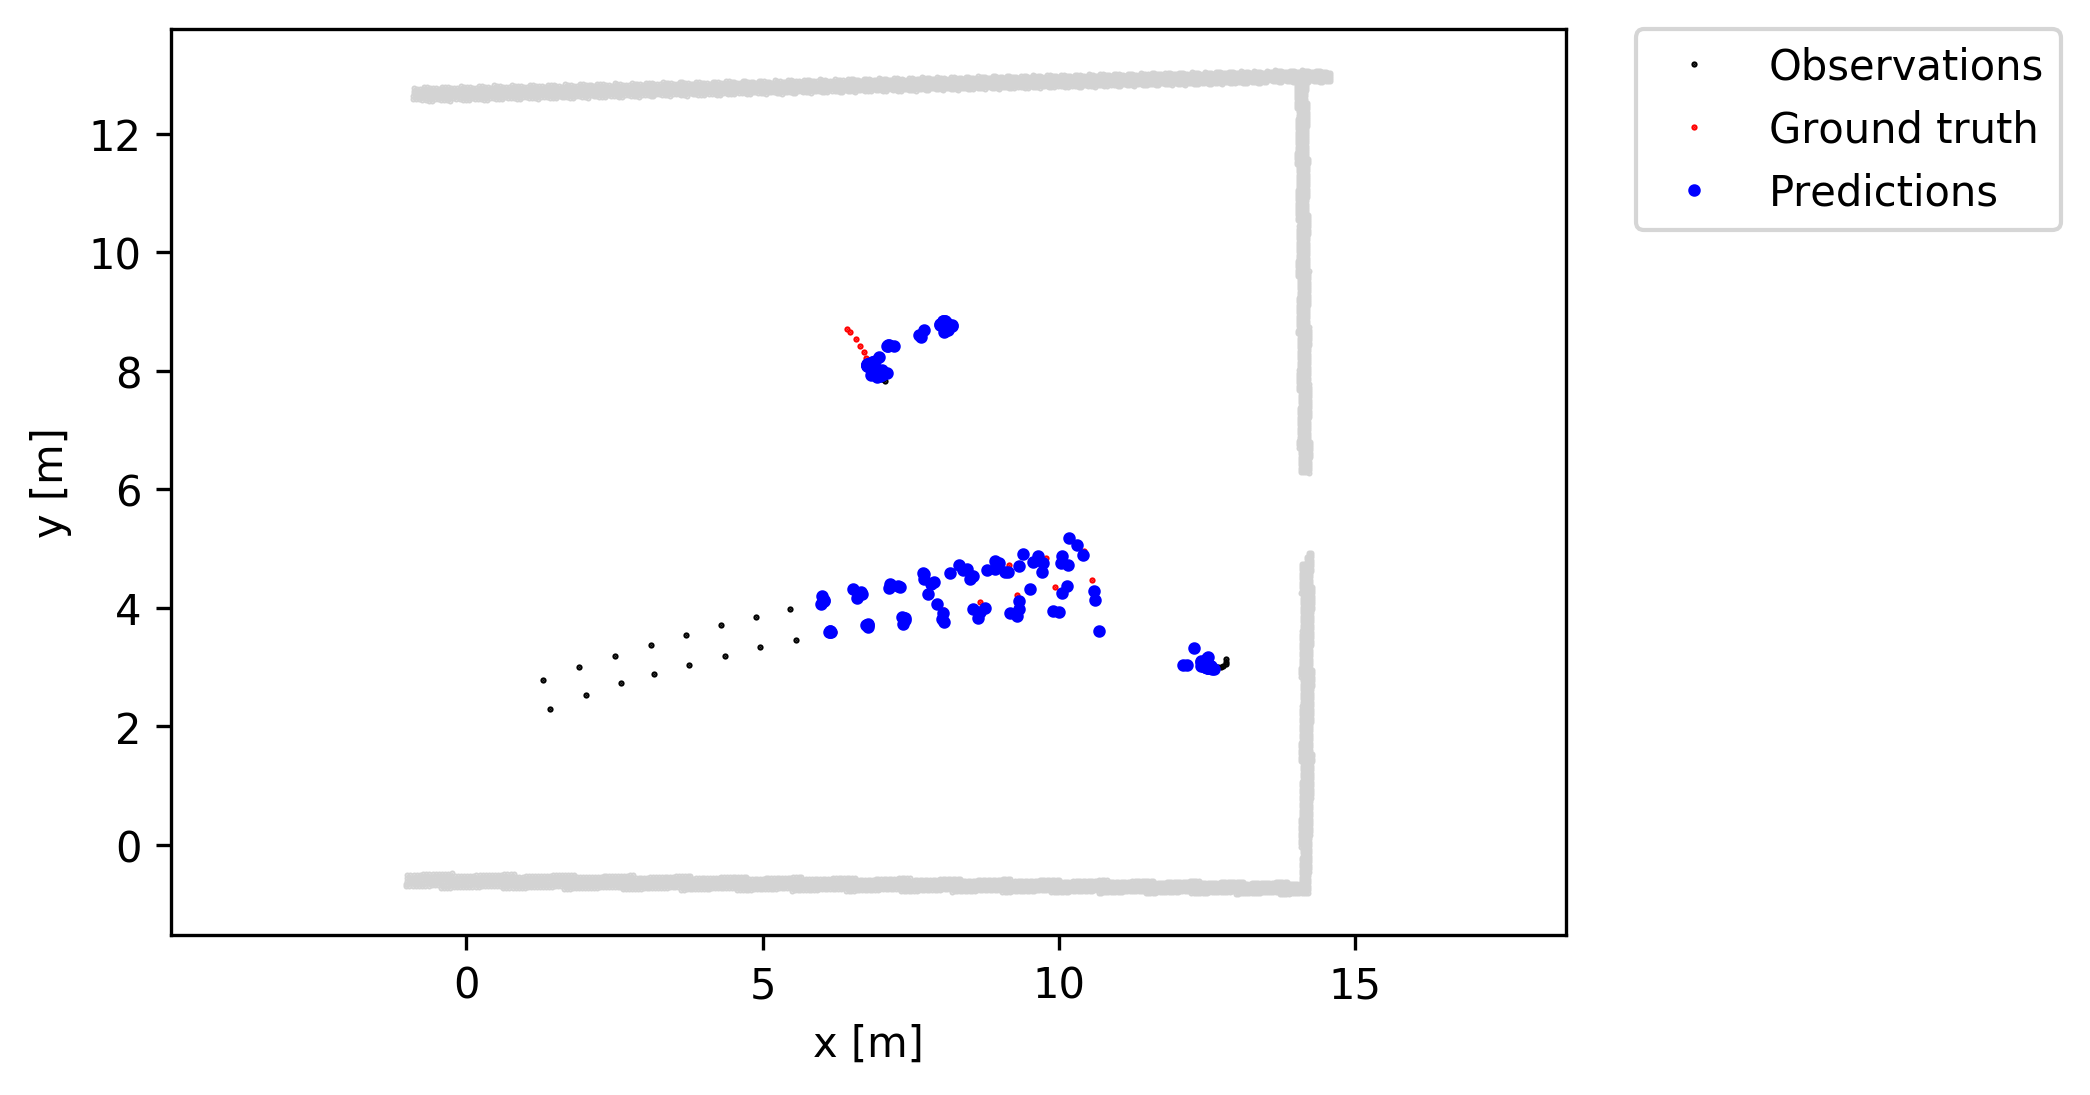

In [6]:
method_cfg['num_particles'] = 5
predictor_uncertain = TrajectronPredictor(scenario=valid_scenes[15], dataset=dataset, method_cfg=method_cfg)
predictions = predictor_uncertain.predict(valid_scenes[15])

evaluation.plot_scenario(dataset, valid_scenes[15], predictions)

In [7]:
import numpy as np

results_ade = []
results_kade = []
for i in range(len(valid_scenes)):
    predictions = predictor_uncertain.predict(valid_scenes[i])
    metric_values_ade = evaluation.evaluate_scenario_ade_fde(valid_scenes[i],predictions)
    metric_values_kade = evaluation.evaluate_scenario_kade_kfde(valid_scenes[i],predictions)
    results_ade.append(metric_values_ade)
    results_kade.append(metric_values_kade)

print('The mean ADE is', np.mean([result[0] for result in results_ade]), '+-', np.std([result[0] for result in results_ade]))
print('The mean FDE is', np.mean([result[1] for result in results_ade]), '+-', np.std([result[1] for result in results_ade]))
print('The mean kADE is', np.mean([result[0] for result in results_kade]), '+-', np.std([result[0] for result in results_kade]))
print('The mean kFDE is', np.mean([result[1] for result in results_kade]), '+-', np.std([result[1] for result in results_kade]))

The mean ADE is 0.2812068452869589 +- 0.09702868673135868
The mean FDE is 0.62738663212733 +- 0.23210953905384665
The mean kADE is 0.16023744162072748 +- 0.07448754619118611
The mean kFDE is 0.35963266333001553 +- 0.17589152168899
